In [24]:
"""Test the radiosity.Radiosity module."""
import numpy as np
import pyfar as pf
import sparrowpy as sp
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
# %matplotlib ipympl

Define the parameters and geometry for the simulation.

In [30]:
# room dimensions
X = 10
Y = 10
Z = 10
R = 1.5
height = 1  # height of the source

patch_max_size = 2
patch_dec = 0.01
patch_min_size = 0.05
ir_length_s = 0.2
sampling_rate = 10000
max_order_k = 1
speed_of_sound = 346.18
absorption = 1  # param default 0.1

# create geometry
# circleRes = np.arange(0, 2 * np.pi * R, 0.1)  # circle of 1.5 meters
# probeDims = np.column_stack(
#    (np.cos(circleRes), np.sin(circleRes), [5] * len(circleRes)),
# )


walls = sp.testing.shoebox_room_stub(X, Y, Z)
for i in walls:
    i.__setattr__("absorption", 1)
probeUp = [
    sp.geometry.Polygon(
        np.array([[1, 1, Z / 2], [1, 9, Z / 2], [9, 9, Z / 2], [9, 1, Z / 2]]),
        np.array([1, 0, 0]),
        np.array([0, 0, 1]),
    ),
]
[i.__setattr__("absorption", 0) for i in probeUp]
probeDown = [
    sp.geometry.Polygon(
        np.array([[1, 1, Z / 2], [1, 9, Z / 2], [9, 9, Z / 2], [9, 1, Z / 2]]),
        np.array([1, 0, 0]),
        np.array([0, 0, -1]),
    ),
]
probeDown[0].__setattr__("absorption", 1)
# probeUpper = [
#    sp.geometry.Polygon(probeDims, np.array([1, 0, 0]), np.array([0, 0, 1])),
# ]  # top side a=0
# probeUpper[0].__setattr__("absorption", 0)
# probeLower = [
#    sp.geometry.Polygon(probeDims, np.array([1, 0, 0]), np.array([0, 0, -1])),
# ]  # bottom side a=1
# probeLower[0].__setattr__("absorption", 1)
elements = probeUp  # + walls + probeDown
source_pos = np.array([5, 5, 5 + height])
source = sp.geometry.SoundSource(
    source_pos,
    np.array([0, 1, 0]),
    np.array([0, 0, 1]),
)
receiver_pos = np.array([5, 5, 5 + height])  # same as source pos

Calculate old slow approach for comparison.

In [26]:
start = datetime.now()
# init object
patch_values = [
    (i / 100)
    for i in range(
        (int)(patch_max_size * 100),
        (int)(patch_min_size * 100),
        (int)(-patch_dec * 100),
    )
]
radi_planes = [
    sp.radiosity.Radiosity(
        elements,
        i,
        max_order_k,
        ir_length_s,
        speed_of_sound=speed_of_sound,
        sampling_rate=sampling_rate,
    )
    for i in patch_values
]

radi = sp.radiosity.Radiosity(
    elements,
    1.4,
    max_order_k,
    ir_length_s,
    speed_of_sound=speed_of_sound,
    sampling_rate=sampling_rate,
)
radi2 = sp.radiosity.Radiosity(
    elements,
    0.95,
    max_order_k,
    ir_length_s,
    speed_of_sound=speed_of_sound,
    sampling_rate=sampling_rate,
)

# run simulation
[i.run(source) for i in radi_planes]
# radi.run(source)
# radi2.run(source)

# gather energy at receiver
receiver = sp.geometry.Receiver(
    receiver_pos, np.array([0, 0, -1]), np.array([0, 1, 0])
)
histograms = [
    i.energy_at_receiver(receiver, ignore_direct=True) for i in radi_planes
]
# hist_s = radi.energy_at_receiver(receiver, ignore_direct=True)
# hist_s2 = radi2.energy_at_receiver(receiver, ignore_direct=True)

# stop timer
delta = datetime.now() - start
print(f"Time elapsed: {delta}")
slow_time_s = (delta.seconds * 1e6 + delta.microseconds) / 1e6

C:\Users\klingelnberg\BA\sparrowpy\sparrowpy\radiosity.py:68: RuntimeWarning: invalid value encountered in divide
  real_size = size / patch_nums


Time elapsed: 0:00:11.353756


Calculate the analytical reference after Kuttruff.

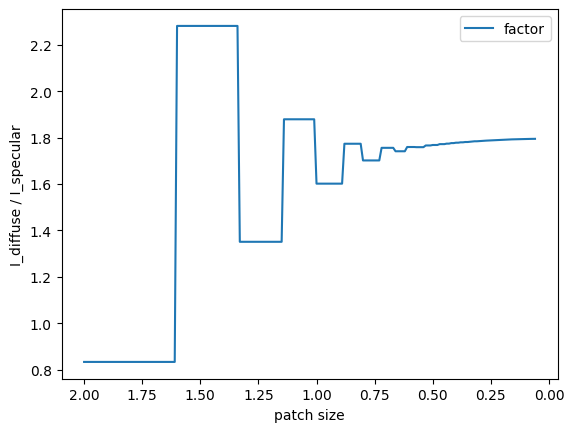

In [29]:
S = np.pi * R**2
A = S * 0
alpha_dash = A / S
r_h = 1 / 4 * np.sqrt(A / np.pi)
# print(f"reverberation distance is {r_h}m")
# V = 1
# RT = 24 * np.log(10) / (speed_of_sound) * V / (-S * np.log(1 - alpha_dash))
# print(f"reverberation time is {RT}s")
# E_reverb_analytical = 4 / A
# t = reverberation_slow.times
# Kuttruff Eq 4.7
# w_0 = E_reverb_analytical / V
# t_0 = 0.03
# Kuttruff Eq 4.10
# reverberation_analytic = w_0 * np.exp(
#    +(speed_of_sound * S * np.log(1 - alpha_dash) / (4 * V)) * (t - t_0)
# )
# reverberation_analytic = pf.Signal(
#    reverberation_analytic, sampling_rate=sampling_rate
# )

# Signal
I_diffuse_planes = [
    pf.Signal(i, sampling_rate=sampling_rate) for i in histograms
]
# I_diffuse = pf.Signal(hist_s, sampling_rate=sampling_rate)
# I_diffuse2 = pf.Signal(hist_s2, sampling_rate=sampling_rate)

I_specular = 1 / (4 * np.pi * (height * 2) ** 2)
factors = [np.sum(i.time[:, :]) / I_specular for i in I_diffuse_planes]
# factor = np.sum(I_diffuse.time[:, :]) / I_specular
# factor2 = np.sum(I_diffuse2.time[:, :]) / I_specular
# print(f"Factor is {factor}x and for smaller patches {factor2}x")
# 1.7953462108378138x for patch_size 0.05 optimal result

# Plot the factors
plt.figure()
plt.plot(patch_values, factors, label="factor")
plt.gca().invert_xaxis()
plt.xlabel("patch size")
plt.ylabel("I_diffuse / I_specular")
plt.legend()
plt.show()

Plot comparison

In [12]:
plt.figure()

pf.plot.time(
    I_diffuse,
    dB=True,
    log_prefix=10,
    label="I_diffuse_time",
    unit="ms",
)
pf.plot.time(
    I_diffuse2,
    dB=True,
    log_prefix=10,
    label="I_diffuse_time_small_patches",
    unit="ms",
)

plt.xlim(0, 300)
plt.legend()
plt.show()

NameError: name 'I_diffuse' is not defined

<Figure size 640x480 with 0 Axes>

Find signal points

In [14]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

sparrowpy : 0.1.0
pyfar     : 0.7.1
matplotlib: 3.10.0
numpy     : 2.1.3

